In [1]:
import pandas as pd
import re
import nltk
from collections import Counter

In [2]:
# load data
songs_data = pd.read_csv("data/top50_2018_2022.csv")
bad_words_data = pd.read_csv("data/bad-words.csv")
bad_words_data

,jigaboo
0,mound of venus
1,asslover
2,s&m
3,queaf
4,whitetrash
...,...
1611,cocky
1612,transsexual
1613,unfuckable
1614,bestiality


In [3]:
# primary artists -> separate by comma
songs_data["Primary Artists"] = songs_data["Primary Artists"].str.replace(" & ",",")
songs_data["Primary Artists"] = songs_data["Primary Artists"].str.replace(", ", ",")
songs_data["Primary Artists"] = songs_data["Primary Artists"].str.split(",")

In [96]:
songs_data["Primary Artists"]

0                             [Drake]
1      [Cardi B, Bad Bunny, J Balvin]
2                             [Drake]
3                       [Post Malone]
4                             [Drake]
                    ...              
245                      [Juice WRLD]
246       [Baby Keem, Kendrick Lamar]
247                        [Rod Wave]
248             [Megan Thee Stallion]
249                    [Armani White]
Name: Primary Artists, Length: 250, dtype: object

In [4]:
def preprocess_lyrics(lyrics):
    # Remove punctuation
    lyrics = re.sub('[^a-zA-Z0-9\s]', '', lyrics)
    # Convert to lowercase
    lyrics = lyrics.lower()
    # Tokenize into individual words
    words = nltk.word_tokenize(lyrics)
    return words

In [17]:
def word_list_to_df(words):
    df = pd.DataFrame.from_dict(Counter(words), orient="index", columns=["count"]).reset_index()
    df.index.name = "word"
    return df

In [18]:
# a table of ALL words (independent of any other variable)
used_words = []
for lyrics in songs_data["Lyrics"]:
    for word in preprocess_lyrics(lyrics):
        used_words.append(word)

all_words_df = word_list_to_df(used_words)

In [19]:
# a table of words FOR EACH year
words_year_dfs = {}
for year in songs_data["year"].unique():
    words_year_dfs[year] = []

# combine all lyrics of a year
year_lyrics_df = songs_data.groupby("year")["Lyrics"].apply(' '.join).reset_index()
for year in words_year_dfs.keys():
    lyrics_of_that_year = year_lyrics_df.loc[year_lyrics_df["year"]==year, "Lyrics"].values[0]
    words=preprocess_lyrics(lyrics_of_that_year)
    words_year_dfs[year] = word_list_to_df(words)

In [21]:
words_year_dfs[2020]

,index,count
word,,
0,pullin,11
1,out,125
2,the,934
3,coupe,16
4,at,80
...,...,...
3709,labels,1
3710,wifi,1
3711,johnny,1


In [22]:
# a table of words FOR EACH primary artist
words_artist_dfs = {}
# if multiple primary artists: EXPLODE!! (means per duplicate row for each artist)
exploded_songs_data = songs_data.explode('Primary Artists')
for artist in exploded_songs_data["Primary Artists"].unique():
    words_artist_dfs[artist] = []

# combine all lyrics of an artist
artist_lyrics_df = exploded_songs_data.groupby("Primary Artists")["Lyrics"].apply(' '.join).reset_index()
for artist in words_artist_dfs.keys():
    lyrics_of_that_artist = artist_lyrics_df.loc[artist_lyrics_df["Primary Artists"]==artist, "Lyrics"].values[0]
    words=preprocess_lyrics(lyrics_of_that_artist)
    words_artist_dfs[artist] = word_list_to_df(words)

In [23]:
words_artist_dfs["Post Malone"]

,index,count
word,,
0,damn,7
1,my,80
2,ap,7
3,goin,12
4,psycho,7
...,...,...
608,tummy,1
609,cigarette,1
610,lungs,1


In [139]:
for i,j in enumerate(words_year_dfs):
    print(i)

0
1
2
3
4


In [142]:
# create swear word column to each
swear_all_words_df = all_words_df
swear_all_words_df["swearword"] = all_words_df["index"].isin(bad_words_data["jigaboo"])

swear_words_year_dfs = words_year_dfs
for k in words_year_dfs.keys():
    swear_words_year_dfs[k]["swearword"] = words_year_dfs[k]["index"].isin(bad_words_data["jigaboo"])

swear_words_artist_dfs = words_artist_dfs
for k in words_artist_dfs.keys():
    swear_words_artist_dfs[k]["swearword"] = words_artist_dfs[k]["index"].isin(bad_words_data["jigaboo"])

In [144]:
import seaborn as sns
import matplotlib.pyplot as plt

allWords:
wordCloud (hue: swearword)
wordCloud (only swearword)
proportion of swearwords

year:
how the proportion developed
most pop. swearword per year
development of each swear word?

artist:
most toxic artist

song:
position of song with respect to swearword % -> is the correlation?

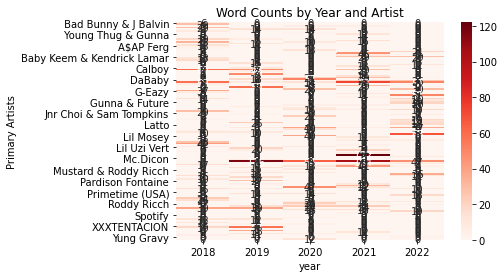

In [146]:
# chatgpt
df = pd.read_csv('data/top50_2018_2022.csv')
df['Lyrics'] = df['Lyrics'].str.lower()
df['Primary Artists'] = df['Primary Artists'].str.split(',')
grouped_df = df.explode('Primary Artists').groupby(['year', 'Primary Artists']).agg({'Lyrics': lambda x: ' '.join(x)})
pivot_df = pd.pivot_table(grouped_df, index='Primary Artists', columns='year', values='Lyrics', aggfunc=lambda x: ' '.join(x)).fillna('')
swearwords = ['fuck', 'shit', 'bitch', 'ass', 'damn']
cmap = sns.color_palette('Reds', as_cmap=True)
sns.heatmap(pivot_df.apply(lambda x: x.str.count('|'.join(swearwords))), cmap=cmap, annot=True, fmt='d')
plt.title('Word Counts by Year and Artist')
plt.show()

In [ ]:
'